# OpenWorld segmentation with MaskClip

In this practical session, we study an simple approach to *Open World* segmentation and recognition.
We will use a method based on [MaskClip](https://www.mmlab-ntu.com/project/maskclip/) that provides open segmentation in the image space.

In our case, we will do it in the point cloud space.
We will use a scene of the [nuScenes dataset](https://www.nuscenes.org/) which is one the most complete dataset for autonomous driving.

*Note:* in order to use the data provided along with the notebook, you must comply to the License on the website of the nuScenes.

*Important:* the data provided here is for the course only, it has been modified for the practical session purposes.

### Notebook and data setup

We first download the data and import the librairies needed for the practical session:

In [ ]:
# downloading the data (if not already present on the drive)
import os
if not os.path.exists("./driving.hdf5"):
  !wget https://github.com/aboulch/MSIA_points/releases/download/v0.0.1/driving.tar.gz
  !tar -xvzf driving.tar.gz

In [ ]:
# install the mising
try:
  import open_clip
except:
  !pip install --no-dependencies open_clip_torch
  !pip install ftfy

#### Import of the libraries and choice of the device

We now import the libraries required for program.
We also define the device to run the notebook.

The device is set to *cpu* for the first part of the session (not learning required), for the second half of the notebook, we will switch to *cuda*.
Note that all the session can be done without cuda support, inferences through networks will only be slower.

In [ ]:
import os
import plotly.graph_objects as go # for visualization
import tqdm
import numpy as np
import torch
import open_clip
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from torchvision.transforms import Normalize, Compose, ToTensor, Resize, CenterCrop

device=torch.device("cpu")

We define the display function for the points.
Images will be displaued with `matplotlib`.

In [ ]:
# display the point cloud
def point_cloud_visu(pts, cls=None):

    marker_dict = dict(size=3,
                            color=cls,
                            )

    if (cls is not None) and (
        len(cls.shape)==1 or
        (len(cls.shape)==2 and (cls.shape[1]==1))):
      marker_dict["colorscale"] = 'Viridis'

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=pts[:,0], y=pts[:,1], z=pts[:,2],
                mode='markers',
                marker=marker_dict,
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode="data", #this string can be 'data', 'cube', 'auto', 'manual'
                #a custom aspectratio is defined as follows:
                aspectratio=dict(x=1, y=1, z=0.95)
            )
        )
    )
    fig.show()

### Data

The data is stored in a `.hdf5` file (see [here](https://docs.h5py.org/en/stable/quick.html)).
Once opened, one can use it as a dictionary.

In the database, there are 39 lidar frames, with corresponding images:

![](https://www.nuscenes.org/static/media/data.9ef46c59.png)

The images are acquired along with the lidar.
There are 6 cameras:
- 'CAM_BACK_LEFT'
- 'CAM_BACK_RIGHT'
- 'CAM_BACK'
- 'CAM_FRONT_LEFT'
- CAM_FRONT_RIGHT'
- 'CAM_FRONT'

We also provide the corresponding intrinsics (one matrice per camera for all frames) and the transformation matrics (ego to global, sensor to ego) for both the camera and the lidar.

In [ ]:
database = h5py.File('driving.hdf5', 'r')
list(database.keys())

### Transformation and data loading

**Question 1:** fill the function that loads the point cloud correspondind to `index` and return a torch tensor on the correct device.

In [ ]:
def load_pc(database, index, device):
  # TODO
  points = torch.rand((100,3))
  return points

points = load_pc(database, 0, device)
point_cloud_visu(points[::10], points[::10,2])

In practice, we need more than just the points, we need also the transformation matrices that allow us to change the coordinate system from one sensor to another.

**Question 2:** following the model of the previous question. Fill the function which loads a point cloud, and the corresponding matrices:
- lidar_points
- lidar_to_ego_rot
- lidar_to_ego_trans
- lidar_ego_to_global_rot
- lidar_ego_to_global_trans
and return them as torch tensors on the designated device.

In [ ]:
def get_lidar_data(database, index, device):
  points = None
  lidar_to_ego_rot = None
  lidar_to_ego_trans = None
  lidar_ego_to_global_rot = None
  lidar_ego_to_global_trans = None

  assert(isinstance(points, torch.Tensor))
  return points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans

**Question 3:** Fill the two functions transforming a point cloud given a rotation matrix $R$ and a translation $t$.

$P' = RP + t$

where $P$ has size $[3,N]$

*Note:* if $P$ has a size $[N,3]$, instead of doing a left multiplication, it is possible to do a right multiplication with $R^T$

In [ ]:
def transform_point_cloud(points, rot, trans):
    assert(isinstance(points, torch.Tensor))
    # TODO
    pts = points
    return pts

def inverse_transform_point_cloud(points, rot, trans):
    # TODO
    pts = points
    return pts

points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)

# one way and back
points_transformed = transform_point_cloud(
                        points,
                        lidar_to_ego_rot,
                        lidar_to_ego_trans)
points_transformed = inverse_transform_point_cloud(
                        points_transformed,
                        lidar_to_ego_rot,
                        lidar_to_ego_trans)
print((points-points_transformed).max()) # should be very small

**Question 4:** fill the function that convert a point cloud form the sensor to the global coordinate system (it goes first to the ego reference and then to the global one).

In [ ]:
def transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              ):
    # TODO
    points_global = points
    return points_global


# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)
points_global_0 = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )

points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 1, device)
points_global_1 = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )

# the two point cloud should be close, with a slight translation (the car is moving)
point_cloud_visu(
    np.concatenate([
        points_global_0[::10],
        points_global_1[::10]], axis=0),
    np.concatenate([
        np.full((points_global_0[::10].shape[0],), 0),
        np.full((points_global_1[::10].shape[0],), 1),], axis=0)
    )

**Question 5:** fill the function that loads the images and corresponding transformation matrices (to ego, and then from ego to global). It should also load the instrinsics and the image.

In [ ]:
def get_image_data(database, cam_name, index, device):
  intrinsics = None
  im = None
  sensor_ego_to_global_rot = None
  sensor_ego_to_global_trans = None
  sensor_to_ego_rot = None
  sensor_to_ego_trans = None

  assert(isinstance(im, torch.Tensor))
  assert(im.dtype == torch.uint8)
  return im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans


im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, "CAM_FRONT", 0, device)
plt.imshow(im)

**Question 6:** fill the function `transform_global_to_sensor` which transform a point cloud in the global coordinate system to the local coordinate system of a sensor.

In [ ]:
def transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans,
        ):
  # TODO
  points_sensor = points_global
  return points_sensor


# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)
im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, 'CAM_FRONT', 0, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )
points_sensor = transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans)


# the point clouds centers should be close
# but y and z axis should be swaped
point_cloud_visu(
    torch.cat([
        points[::20].cpu(),
        points_sensor[::20].cpu()], axis=0),
    torch.cat([
        torch.full((points[::20].shape[0],), 0),
        torch.full((points_sensor[::20].shape[0],), 1),], axis=0)
    )

The depth in the camera is given in the $z$ coordinate of the point cloud in the camera coordinate system.
We give a function `get_depth_from_image_in_camera` which extract the depth.



In [ ]:
def get_depth_from_image_in_camera(points_cam):
    return points_cam[:,2]

Now that the points can be projected in the camera coordinate system, it is left to associate each point with its coordinate in the image space (pixel space). To do so, we use the intrisic camera.

**Question 7:** fill the `project_points_in_pixel_space_function`. It does two things:
* multiply the points by the intrinsic matrix (for multiplication on the right, use the transpose of the intrinsics).
* normalize the pixel coordinates (two first coordinates of each points after multiplication) by the third coordinate (division by $z$).

The result should look like that: (The points are not centered so you must play with the viewer to see it)

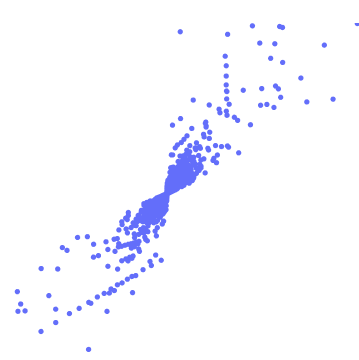

In [ ]:
def project_points_in_pixel_space(points_cam, intrinsics):
  # TODO
  points_pixel_coords = points_cam.clone()
  return points_pixel_coords

# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)
im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, 'CAM_FRONT', 0, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )
points_sensor = transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans)

points_pixel_coords = project_points_in_pixel_space(points_sensor, intrinsics)

point_cloud_visu(
    points_pixel_coords
    )


**Question 8:** Only part of the points are visible in the image. These points must meet several requirements:
* depths should be positive
* points coordinates should be in the range $[1, H-1]$  (for x) and $[1,W-1]$ for y.

The function returns a boolean mask corresponding the points with a valid projection.

In [ ]:
def filter_points_in_image(points, depths, im):
    # TODO
    mask = None
    return mask

# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)
im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, 'CAM_FRONT', 0, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )
points_sensor = transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans)

points_pixel_coords = project_points_in_pixel_space(points_sensor, intrinsics)
depths = get_depth_from_image_in_camera(points_sensor)
mask_points_in_image = filter_points_in_image(points_pixel_coords, depths, im)

# point cloud visualization
point_cloud_visu(points_global.cpu(), mask_points_in_image.cpu().float())

# display image with reprojected points
dot_size = 10
plt.imshow(im.cpu())
plt.scatter(points_pixel_coords[mask_points_in_image][:,0].cpu(),
            points_pixel_coords[mask_points_in_image][:,1].cpu(),
            c=depths[mask_points_in_image].cpu(),
            s=dot_size)

Finally, we get the features associated to the points when projected on the image (using the previoulsy computed coordinates in pixel space) and associate them to the global point cloud.


**Question 9:** fill the function `get_image_features` that return the image features associated with valid points (using the mask).

Result should look like below.

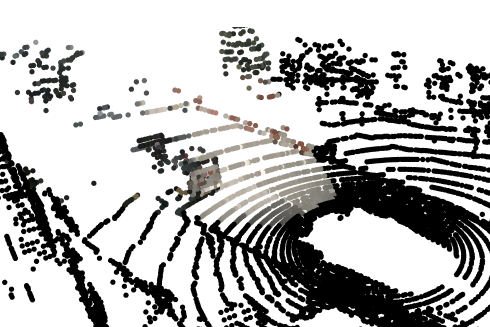

In [ ]:
def get_image_features(points_pixel_coords,
                       mask_points_in_image,
                       image_fts,
                       ):
    # TODO
    features = None
    return features

# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, 0, device)
im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, 'CAM_FRONT', 0, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )
points_sensor = transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans)

points_pixel_coords = project_points_in_pixel_space(points_sensor, intrinsics)
depths = get_depth_from_image_in_camera(points_sensor)
mask_points_in_image = filter_points_in_image(points_pixel_coords, depths, im)

color_features_valid = get_image_features(points_pixel_coords,
                       mask_points_in_image,
                       im)
color_fts = torch.zeros((points_global.shape[0],3), dtype=torch.uint8, device=device)
color_fts[mask_points_in_image] = color_features_valid
point_cloud_visu(points_global.cpu(), color_fts.cpu())

### Maskclip

Most of the geometric code has been done.
Now, we come to the generation of features that will be associated with the points and allow open world queries.

To do so, we will use a [CLIP model](https://openai.com/index/clip/) and extend it to segmentation using [MaskCLIP](https://www.mmlab-ntu.com/project/maskclip/).

We will base our code on [OpenClip library](https://github.com/mlfoundations/open_clip).


#### CLIP

![](https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/CLIP.png)

From https://github.com/openai/CLIP

CLIP consists in two models, one for text and one for images, trained jointly such that text encoder for image caption and image encoder for RGB images produce the same output.
It uses a contastive loss in order to avoid collapse during training.

At inference it is possible compute the similarity of an image embedding and a text embedding.

**Question 10:** using the example on the open clip github [here](https://github.com/mlfoundations/open_clip), setup the model for a ResNet50 (`RN50`) from OpenAI training (`pretrained='openai'`) and the corresponding tokenizer. Set the model to the correct device.
Here we set it as cpu, but it can be changed (faster computation), but it is not required.

The answer should somthing like:

`Label probs: tensor([[0.9511, 0.0462, 0.0027]], device='cuda:0')`

In [ ]:
device = torch.device("cpu")

In [ ]:
# get the image
im  = get_image_data(database, 'CAM_FRONT', 0, device)[0]
im = Image.fromarray(im.cpu().numpy())

# Text classes we want to test
text_class_list = ["a road", "a cat", "a rocket"]

# model setup
# here we should have a model, a preprocess and a tokenizer

# Predict image features (these should be normalized)
# with torch.no_grad():
# image = ...
# image_features = ...

# Predict the text features (these should be normalized)
# text = ...
# text_features = ...

# compute correlation + sofmax --> the 100.0 just increase the temperature in the softmax
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]


#### MaskCLIP

At this stage, we only produce one features embedding per image (this the analogous of classification).
If we want to do segmentation, we need to modify the pipeline. To do so, we will use MaskCLIP:

![](https://www.mmlab-ntu.com/project/maskclip/img/architecture.png)

We will do it with the Vanilla version (MaskCLIP+ requires module finetuning).



MaskCLIP modifies the attention pooling (last layer of the model) to do a dense prediction.

In [ ]:
model.visual

**Question 11** Modify the model (the visual part only):
- extract in a variable, the `v_proj` layer of the visual model
- extract in a variable, the `c_proj` layer of the visula model
- replace the attention pooling model with a identity layer

Fill the function `get_model` which create an openclip RN50 model, modifies the visual model, set it eval mode, on the correct device and returns (the model, the tolenizer, the `v_proj` and `c_proj` layers).

In [ ]:
# model setup
def get_model(model_name, pretrained, device):
  # TODO
  # model, preprocess ...
  v_proj = None
  c_proj = None

  return model, tokenizer, v_proj, c_proj

**Question 12:** fill the `infer_image_features` function which, convert the image to a PIL image, and to inference of the model in inference mode (torch no_grad), then go through `v_proj` and `c_proj` to finally be normalized (in the feature dimension) and permuted such that the output is of shape:

`torch.Size([1, 7, 7, 1024])`

In [ ]:
def infer_image_features(model, im, v_proj, c_proj):
  # convert the image to PIL image
  image_features = None
  return image_features

# get the image
im  = get_image_data(database, 'CAM_FRONT', 0, device)[0]
model, tokenizer, v_proj, c_proj = get_model('RN50', 'openai', device)
im_fts = infer_image_features(model, im, v_proj, c_proj)

print(im_fts.shape)


#### Prompt engineering

In practice, using a single class name is not the most efficient.
We can do "prompt engineering" which consists in testing several text templates (different classes) and averaging the results.

**Question 13:** compute the text features for all the prompt templates.

In [ ]:
def compute_text_features(cls, device):

  if device == torch.device('cpu'):
    prompt_templates = [
        'a photo of a {}.', 'a low resolution photo of the {}.'
    ]
  elif device == torch.device('cuda'):
    prompt_templates = [
        'a bad photo of a {}.', 'a photo of many {}.', 'a sculpture of a {}.', 'a photo of the hard to see {}.', 'a low resolution photo of the {}.', 'a rendering of a {}.', 'graffiti of a {}.', 'a bad photo of the {}.', 'a cropped photo of the {}.', 'a tattoo of a {}.', 'the embroidered {}.', 'a photo of a hard to see {}.', 'a bright photo of a {}.', 'a photo of a clean {}.', 'a photo of a dirty {}.', 'a dark photo of the {}.', 'a drawing of a {}.', 'a photo of my {}.', 'the plastic {}.', 'a photo of the cool {}.', 'a close-up photo of a {}.', 'a black and white photo of the {}.', 'a painting of the {}.', 'a painting of a {}.', 'a pixelated photo of the {}.', 'a sculpture of the {}.', 'a bright photo of the {}.', 'a cropped photo of a {}.', 'a plastic {}.', 'a photo of the dirty {}.', 'a jpeg corrupted photo of a {}.', 'a blurry photo of the {}.', 'a photo of the {}.', 'a good photo of the {}.', 'a rendering of the {}.', 'a {} in a video game.', 'a photo of one {}.', 'a doodle of a {}.', 'a close-up photo of the {}.', 'a photo of a {}.', 'the origami {}.', 'the {} in a video game.', 'a sketch of a {}.', 'a doodle of the {}.', 'a origami {}.', 'a low resolution photo of a {}.', 'the toy {}.', 'a rendition of the {}.', 'a photo of the clean {}.', 'a photo of a large {}.', 'a rendition of a {}.', 'a photo of a nice {}.', 'a photo of a weird {}.', 'a blurry photo of a {}.', 'a cartoon {}.', 'art of a {}.', 'a sketch of the {}.', 'a embroidered {}.', 'a pixelated photo of a {}.', 'itap of the {}.', 'a jpeg corrupted photo of the {}.', 'a good photo of a {}.', 'a plushie {}.', 'a photo of the nice {}.', 'a photo of the small {}.', 'a photo of the weird {}.', 'the cartoon {}.', 'art of the {}.', 'a drawing of the {}.', 'a photo of the large {}.', 'a black and white photo of a {}.', 'the plushie {}.', 'a dark photo of a {}.', 'itap of a {}.', 'graffiti of the {}.', 'a toy {}.', 'itap of my {}.', 'a photo of a cool {}.', 'a photo of a small {}.', 'a tattoo of the {}.', 'there is a {} in the scene.', 'there is the {} in the scene.', 'this is a {} in the scene.', 'this is the {} in the scene.', 'this is one {} in the scene.',
    ]

  text = []
  # add prompts to text list
  # ...
  # predict the text_features
  text_features = None

  return text_features

text_features = compute_text_features("road", device)
print("Text features", text_features.shape)


**Question 14:** compute the correlations (scalar products, the features should be normalized) between image feature and text features, and average the correlation scores.

In [ ]:
def compute_correlations(im_fts, text_fts):
  # im_fts [B, 7, 7, 1024]
  # text_fts [num_prompt, 1024]
  correlations = None
  return correlations

im  = get_image_data(database, 'CAM_FRONT', 0, device)[0]
model, tokenizer, v_proj, c_proj = get_model('RN50', 'openai', device)
im_fts = infer_image_features(model, im, v_proj, c_proj)
text_fts = compute_text_features("road", device)
correlations = compute_correlations(im_fts, text_fts)

plt.imshow(correlations[0].cpu())
plt.figure()
plt.imshow(im)


**Question 15:** Project the points in feature map (not the correlation map)using the previous functions, get the features for the valid points.

*Note:* coordinates in image space should be resized to the feature map size.

Result example below.

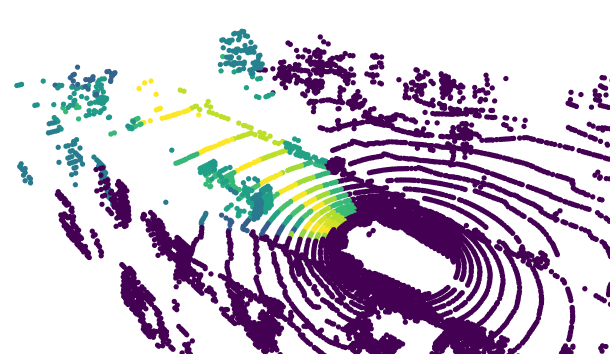

In [ ]:
def project_points_on_image_features(im, im_fts, points_pixel_coords, mask_points_in_image):
  # update the pixel points coords
  pts_fts_valid = None
  return pts_fts_valid

frame_id = 0
image_frame_id = 0
cam_name = 'CAM_FRONT'
clip_feature_size = 1024

# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, frame_id, device)
im, intrinsics, sensor_ego_to_global_rot, sensor_ego_to_global_trans, sensor_to_ego_rot, sensor_to_ego_trans = get_image_data(database, cam_name, image_frame_id, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )
points_sensor = transform_global_to_sensor(points_global,
        sensor_to_ego_rot,
        sensor_to_ego_trans,
        sensor_ego_to_global_rot,
        sensor_ego_to_global_trans)

points_pixel_coords = project_points_in_pixel_space(points_sensor, intrinsics)
depths = get_depth_from_image_in_camera(points_sensor)
mask_points_in_image = filter_points_in_image(points_pixel_coords, depths, im)


# get the image
model, tokenizer, v_proj, c_proj = get_model('RN50', 'openai', device)
im_fts = infer_image_features(model, im, v_proj, c_proj)

pts_fts_valid = project_points_on_image_features(im, im_fts, points_pixel_coords, mask_points_in_image)
print("Pts features valid", pts_fts_valid.shape)

pts_fts = torch.zeros((points_global.shape[0],clip_feature_size), dtype=torch.float, device=device)
pts_fts[mask_points_in_image] = pts_fts_valid


text_fts = compute_text_features("road", device)
correlations = compute_correlations(pts_fts, text_fts)

point_cloud_visu(points_global.cpu(), correlations.cpu())


**Question 16:** do the same but over the six cameras and for the `image_frame_range` timesteps before and after the `frame_id`.

*Note:* features should be summed when a points is seen in multiple cameras.
*Note2:* point features should be normalized at the end

In [ ]:
frame_id = 5
min_frame_id = 0
max_frame_id = 38
image_frame_range = 2
clip_feature_size = 1024
cam_sensors = ['CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_FRONT_LEFT',
               'CAM_FRONT_RIGHT', 'CAM_FRONT',]

print("Frame id:", frame_id)

# get one point cloud
points, lidar_to_ego_rot, lidar_to_ego_trans, lidar_ego_to_global_rot, lidar_ego_to_global_trans = get_lidar_data(database, frame_id, device)

points_global = transform_lidar_to_global(points,
                              lidar_to_ego_rot,
                              lidar_to_ego_trans,
                              lidar_ego_to_global_rot,
                              lidar_ego_to_global_trans,
                              )

pts_fts = torch.zeros((points_global.shape[0],clip_feature_size), dtype=torch.float, device=device)

model, tokenizer, v_proj, c_proj = get_model('RN50', 'openai', device)

# for image_frame_id in ...

text_fts = compute_text_features("road", device)
correlations = compute_correlations(pts_fts, text_fts)

point_cloud_visu(points_global.cpu(), correlations.cpu())

**Question 17:** do the same for multiple lidar frames (and concatenate the points and the features).

In [ ]:
def multiple_lidar_projection(lidar_start, lidar_end, image_frame_range, model, v_proj, c_proj ):

  # constants
  min_frame_id = 0
  max_frame_id = 38
  clip_feature_size = 1024
  cam_sensors = ['CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_FRONT_LEFT',
                'CAM_FRONT_RIGHT', 'CAM_FRONT',]

  # TODO

  assert(isinstance(all_points_global, torch.tensor))
  assert(isinstance(all_pts_fts, torch.tensor))
  return all_points_global, all_pts_fts


lidar_start = 0
lidar_end = 5
image_frame_range = 2

model, tokenizer, v_proj, c_proj = get_model('RN50', 'openai', device)

points_global, pts_fts = multiple_lidar_projection(lidar_start, lidar_end, image_frame_range, model, v_proj, c_proj )

text_fts = compute_text_features("road", device)
correlations = compute_correlations(pts_fts, text_fts)

point_cloud_visu(points_global.cpu(), correlations.cpu())

**Question 18:** test several other class (e.g. truck, packages...).

For packages, you can plot the image 'CAM_FRONT_LEFT' of the frame number 3.